# Chess games data analysis

## Motivation

The intention of this data analysis is to build a model that, given information about a Chess game's initial configuration, can suggest opening sequences that result in higher likelihoods of success.  Although the model won't be able to make highly-accurate predictions about a game's winner before the game is played, it should be able to confidently rank the opening moves to provide players with a little guidance on how to start their games.

## Imports

In [1]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import os
import urllib
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Loading the data

The data has been originally sourced from [Kaggle](https://www.kaggle.com/datasnaek/chess) and is hosted on [GitHub](https://github.com/ChrisJMurdoch/ChessGameData) for convenience.

To speed up this part for multiple runs, you can clone the repository to ./data/

In [2]:
LOCAL_SRC = "./data/"
GITHUB_SRC = "https://raw.githubusercontent.com/ChrisJMurdoch/ChessGameData/main/"

In [3]:
try: # Try getting the data locally
    data = pd.read_csv(LOCAL_SRC+"chess_data.csv", index_col=0)
    
except: # Default to GitHub repo
    data = pd.read_csv(GITHUB_SRC+"chess_data.csv", index_col=0)

In [4]:
# Rename some of the lengthier column names
data = data.rename(columns={
    "created_at":"start",
    "last_move_at":"end",
    "victory_status": "status",
    "opening_eco": "eco"
})

## Improving the data

Some useful data can be inferred from existing columns to provide more meaningful results.

### Time and increment

In chess, the time that each player has to make their move is variable.  In the original data, this data is stored as a single string in the form:

 - 10+5 : Each person starts with 10 minutes on their clock, and 5 seconds is added each turn
 - 0+10 : Start with no time on clock, add 10 seconds each turn
 - and so on...

As this does not allow the time and increment values to be recognised as ratio values, we should separate them into columns like so:

In [5]:
data["time"]      = data["increment_code"].apply( lambda code : int(code.split("+")[0])*60 )
data["increment"] = data["increment_code"].apply( lambda code : int(code.split("+")[1]) )

### Start and end times

The columns start and end timestamps should provide good information on when the game was played and how long it lasted.  Unfortunately, the values are stored as floating-point numbers with precision far too low to give meaningful results on duration.  As can be seen below, 43% of the rows report the end time to be exactly the same as the start time.

In [6]:
zero_duration = data["end"] == data["start"]
zero_duration.value_counts(normalize=True)*100

False    57.383588
True     42.616412
dtype: float64

Although we can't get the amount of time the players took to finish the game, we can calculate how much time was available to the players.

Because the time column represents the number of minutes each player has on their clock at the start of the game, and because increment represents the amount of seconds added at the start of their turn, the game's maximum duration can be calculated like so:

In [7]:
data["max_duration"] = (data["time"]*2) + (data["turns"]*data["increment"])
data["max_duration"] = data["max_duration"].clip(upper=20.25*60*60)

Note that the time has been capped at 20.25 hours<sup>1</sup>.  As no player should exceed this time, there is no point in differentiating a player with 21 hours on the clock and one with 100 hours.

<sup>1</sup> [The longest official chess game had 269 moves and lasted 20 hours and 15 minutes.](https://en.wikipedia.org/wiki/List_of_world_records_in_chess)

### Game winner

As winning, drawing and losing in a zero-sum game like chess is easy to quantify, we can change the winner column to a numerical value.  This allows us to calculate the mean winner when aggregating the data.  We can also calculate the difference in ratings into a column so that the difference is preserved when the data is grouped.

In [8]:
data = data.replace({ "winner" : {"white":1, "draw":0, "black":-1} })
data["rating_delta"] = data["white_rating"] - data["black_rating"]

## Cleaning up the data

Before the data is displayed, a few of the unnecessary parts can be removed:


In [9]:
# Drop the columns that aren't needed
data = data.drop([
    'status',               # This allows the classifier to cheat and detect draws easily
    'start', 'end',         # These floats are too low-accuracy to provide meaningful results
    'increment_code',       # Replaced by time and increment
    'white_id', 'black_id', # Player names aren't relevant to this analysis
    'moves',                # This data is complex but may be used later
    'opening_name'          # This can be inferred from opening_eco
], axis=1)

# Change to a more intuitive column order
data = data[[
    "rated", "winner",
    "white_rating", "black_rating", "rating_delta",
    "eco", "opening_ply",
    "turns", "time","increment", "max_duration"
]]

### Invalid rows

To ensure that the data works with the neural network, all of the cells must have valid data in them.  Fortunately, as can be seen below, the data set comes with no incomplete or invalid data.

In [10]:
data[data.isnull().any(axis=1)].head()

,rated,winner,white_rating,black_rating,rating_delta,eco,opening_ply,turns,time,increment,max_duration
id,,,,,,,,,,,


## Describing the data

In [11]:
data.head()

,rated,winner,white_rating,black_rating,rating_delta,eco,opening_ply,turns,time,increment,max_duration
id,,,,,,,,,,,
TZJHLljE,False,1,1500,1191,309,D10,5,13,900,2,1826
l1NXvwaE,True,-1,1322,1261,61,B00,4,16,300,10,760
mIICvQHh,True,1,1496,1500,-4,C20,3,61,300,10,1210
kWKvrqYL,True,1,1439,1454,-15,D02,3,61,1200,0,2400
9tXo1AUZ,True,1,1523,1469,54,C41,5,95,1800,3,3885


As can be seen above, the data consists of 11 rows:
 - **rated (nominal)**: If the game was ranked by skill
 - **winner (ratio)**: Who won the game
 - **white_rating (interval)**: Skill rating of white player
 - **black_rating (interval)**: Skill rating of black player
 - **rating_delta (ratio)**: Difference in skill ratings (white-black)
 - **eco (nominal)**: ECO code for game opening used
 - **opening_ply (ratio)**: How many moves conformed to the opening sequence
 - **turns (ratio)**: How many turns the game lasted
 - **time (ratio)**: How many seconds each player started with on their clock
 - **increment (ratio)**: How many seconds each player gained at the start of their turn
 - **max_duration (ratio)**: The maximum duration the game could have lasted

In [12]:
from pandas.plotting import scatter_matrix

# Used to colour graph: https://stackoverflow.com/a/50703596
corr = data.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr.style
 .set_precision(2)
 .background_gradient(cmap='PRGn', axis=None, vmin=-.5, vmax=.5)
 .highlight_null(null_color='#f1f1f1'))

,rated,winner,white_rating,black_rating,rating_delta,opening_ply,turns,time,increment,max_duration
rated,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
winner,-0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan
white_rating,0.00,0.14,nan,nan,nan,nan,nan,nan,nan,nan
black_rating,0.03,-0.17,0.63,nan,nan,nan,nan,nan,nan,nan
rating_delta,-0.03,0.36,0.43,-0.43,nan,nan,nan,nan,nan,nan
opening_ply,-0.00,0.02,0.28,0.26,0.03,nan,nan,nan,nan,nan
turns,0.09,-0.04,0.13,0.16,-0.04,0.06,nan,nan,nan,nan
time,-0.11,0.01,-0.07,-0.08,0.01,-0.03,-0.06,nan,nan,nan
increment,-0.10,0.01,-0.02,-0.03,0.01,-0.01,-0.06,0.47,nan,nan
max_duration,-0.11,0.01,-0.05,-0.06,0.00,-0.02,0.00,0.95,0.64,nan


Some correlations that are immediately apparent are:

 - Skill ratings and the winner - higher skill results in higher win chance
 - White and black skill ratings - ranked games pit similarly-rated opponents against each other
 - Rating delta with skill ratings and winner - delta is an engineered attribute from these columns
 - Turns positively correlate with rated games - this may be because players concede/leave less in important rated games
 - Turns and skill rating - Higher skill ratings mean that game-forfeiting mistakes aren't made so often
 - Opening plays and skill rating - higher-skill players will use standard opening moves more often
 - Negative correlation between time limits and rated - not sure about this yet

## Aggregating the data

By grouping the data by the opening code (ECO), we can see that some openings are a lot more effective than others.

In [13]:
# Create new column to count unique occurrences (can't use index with agg())
data["unique"] = data.index

# Group by ECO code
grouped = data.groupby('eco').agg({'winner':'mean', 'unique':'size'})

# Discard counting column
data = data.drop(['unique'], axis=1)

# Filter out the openings with few recorded uses
filtered = grouped[grouped["unique"] > 160]

# Display data sorted by mean win-rate for white
filtered = filtered.sort_values("winner")
filtered

,winner,unique
eco,,
B20,-0.171076,567
A00,-0.170804,1007
A45,-0.126984,252
B30,-0.114537,227
C20,-0.082963,675
B50,-0.066372,226
C50,-0.052045,538
B06,-0.039773,176
D00,-0.025710,739


Because the winner is stored as a ratio, we can find the mean winner of each opening sequence.  This data shows the opening with the highest win rate for white as the popular opening; Queen's Gambit.

<AxesSubplot:xlabel='eco'>

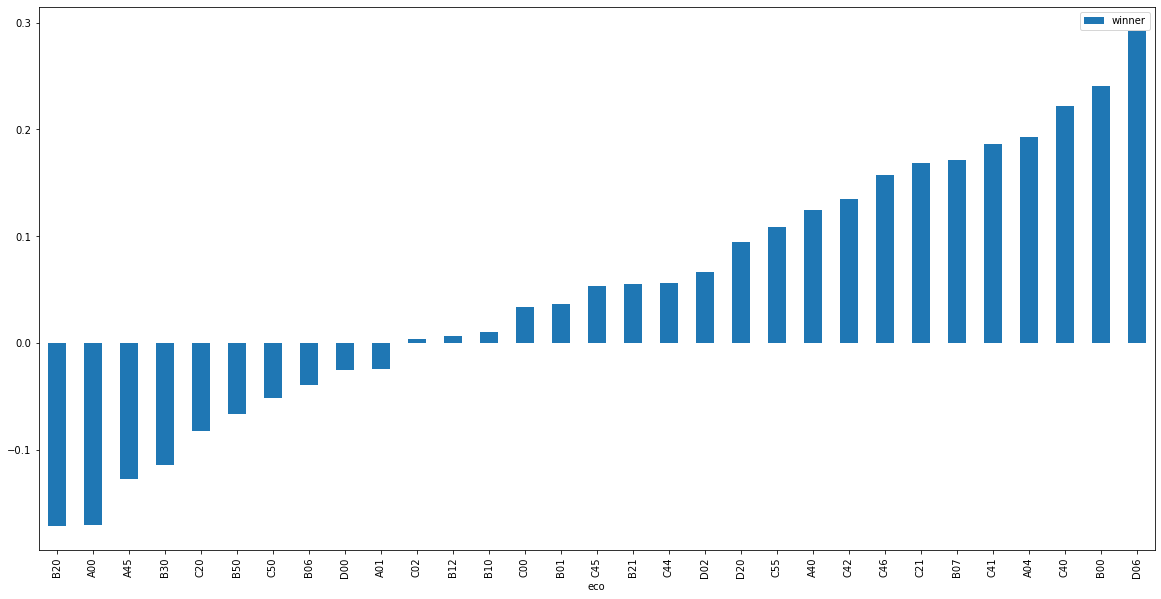

In [14]:
filtered.plot(kind="bar", use_index=True, y='winner', figsize=(20, 10))

Although some openings are more effective than others overall, some should prove to have differing effectiveness depending on the skill level of the user.  Hopefully, the neural network's analysis will reveal what openings are good for players of a certain skill range.

In [15]:
grouped = grouped.sort_values("unique")
grouped["unique"].describe()

count     365.000000
mean       54.953425
std       129.248506
min         1.000000
25%         3.000000
50%        10.000000
75%        36.000000
max      1007.000000
Name: unique, dtype: float64

## Preprocessing the data

To use Naive Bayes, all of the data must be in discrete, numerical form.  This means that continuous or near-continuous data must be put into discrete bins and all non-numerical values should be converted to numerical.

In [16]:
data.head()

,rated,winner,white_rating,black_rating,rating_delta,eco,opening_ply,turns,time,increment,max_duration
id,,,,,,,,,,,
TZJHLljE,False,1,1500,1191,309,D10,5,13,900,2,1826
l1NXvwaE,True,-1,1322,1261,61,B00,4,16,300,10,760
mIICvQHh,True,1,1496,1500,-4,C20,3,61,300,10,1210
kWKvrqYL,True,1,1439,1454,-15,D02,3,61,1200,0,2400
9tXo1AUZ,True,1,1523,1469,54,C41,5,95,1800,3,3885


In [17]:
# Discretise and bin data
def discretise(data):
    discrete = data.copy()
    discrete['white_rating'] = pd.qcut(data['white_rating'], q=10, duplicates='drop')
    discrete['black_rating'] = pd.qcut(data['black_rating'], q=10, duplicates='drop')
    discrete['rating_delta'] = pd.qcut(data['rating_delta'], q=10, duplicates='drop')
    discrete['max_duration'] = pd.qcut(data['max_duration'], q=10, duplicates='drop')
    return discrete

discrete = discretise(data)
discrete.head()

,rated,winner,white_rating,black_rating,rating_delta,eco,opening_ply,turns,time,increment,max_duration
id,,,,,,,,,,,
TZJHLljE,False,1,"(1441.0, 1500.0]","(788.999, 1226.0]","(293.0, 1499.0]",D10,5,13,900,2,"(1800.0, 2280.0]"
l1NXvwaE,True,-1,"(1236.0, 1351.0]","(1226.0, 1346.0]","(39.0, 89.0]",B00,4,16,300,10,"(31.999, 976.0]"
mIICvQHh,True,1,"(1441.0, 1500.0]","(1432.0, 1500.0]","(-29.0, 3.0]",C20,3,61,300,10,"(1200.0, 1430.0]"
kWKvrqYL,True,1,"(1351.0, 1441.0]","(1432.0, 1500.0]","(-29.0, 3.0]",D02,3,61,1200,0,"(2280.0, 3015.0]"
9tXo1AUZ,True,1,"(1500.0, 1567.0]","(1432.0, 1500.0]","(39.0, 89.0]",C41,5,95,1800,3,"(3015.0, 46260.0]"


In [18]:
# Numberise non-numerical columns
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
def numberise(data, include):
    return data.apply(lambda x: encoder.fit_transform(x) if x.name in include else x)

discrete = numberise(
    discrete,
    {'rated', 'status', 'white_rating', 'black_rating', 'rating_delta', 'eco', 'max_duration'}
)
discrete.head()

,rated,winner,white_rating,black_rating,rating_delta,eco,opening_ply,turns,time,increment,max_duration
id,,,,,,,,,,,
TZJHLljE,0,1,3,0,9,248,5,13,900,2,4
l1NXvwaE,1,-1,1,1,6,71,4,16,300,10,0
mIICvQHh,1,1,3,3,4,171,3,61,300,10,2
kWKvrqYL,1,1,2,3,4,241,3,61,1200,0,5
9tXo1AUZ,1,1,4,3,6,192,5,95,1800,3,6


## A note on classifier accuracy

Unlike other potential datasets, this set cannot have a near-perfect accuracy.  Where a dataset on bank loan approval may include all the data needed to make a very accurate prediction, this data on chess game variables only provides a clue as to who may win.  The winner is ultimately decided on how well the participants play.

Because the application of this classifier will be to suggest good openings to players given a set of game variables, the classifier will focus on making the best predictions possible with limited information.

## Using and evaluating the classifiers

Now that the data is in a form that Naive Bayes can work with, it's time to actually use the classifier.  We can use sklearn to quickly train and test the accuracy of a multinomial implementation of Naive Bayes:

In [19]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.model_selection import cross_val_score

# Evaluate score
scores = cross_val_score(MultinomialNB(), discrete.drop(['winner'], axis=1), discrete['winner'], cv=10, scoring="accuracy")
sum(scores) / len(scores)

0.40332993538088974

This is ok, but it can be improved.  Firstly, an accuracy of 0.4 is not as high as it could be which suggests we may be using the wrong implementation of Naive Bayes.  Secondly, the accuracy only shows the percentage of predictions it made that were correct.  It doesn't show other metrics such as how many correct instances it didn't predict.

To better visualise the performance of classifiers and attribute configurations, the following utility has been written to automate training the model, generate a confusion matrix, and report the relevant metrics.

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

def classifier_metrics(classifier, data, class_name, attributes=None):
    """
    Prints performance metrics for the given configuration
    @param classifier: The sklearn classifier with which to classify the data
    @param data: The pandas dataframe containing the instance data
    @param class_name: String stating the name of the column to be used as the output class
    @param attributes: Optional array of strings to specify which columns are to be used for classification
    """
    
    # Optionally get subset of attributes for attributes selection
    if attributes != None:
        if class_name not in attributes:
            attributes.append(class_name)
        data = data[attributes]
    
    # Separate model data from output
    model = data.drop([class_name], axis=1)
    output = data[class_name]
    
    # Print dataframe size
    attributes = len(model.columns)
    print(f'Attributes: {attributes}')
    
    # Train classifier
    classifier.fit(model, output)
    
    # Get confusion matrix
    output_predict = cross_val_predict(classifier, model, output, cv=10)
    confusion = confusion_matrix(output, output_predict)
    
    # Area under ROC curve
    roc = roc_auc_score(output, classifier.predict_proba(model), multi_class='ovr')
    print (f'ROC AUC: {round(roc, 3)}')
    
    # Get precision, recall and f1 values
    print (f'Class metrics:')
    sum_p, sum_r, sum_f = 0, 0, 0
    for i in range(len(confusion)):
        p, r, f = confusion_metrics(confusion, i)
        print(f' - Class {i+1}: Precision: {round(p, 2)} Recall: {round(r, 2)} F1: {round(f, 2)}')
        sum_p += p
        sum_r += r
        sum_f += f
    s = len(confusion)
    avg_p = sum_p/s
    avg_r = sum_r/s
    avg_f = sum_f/s
    print(f' - Average: Precision: {round(avg_p, 2)} Recall: {round(avg_r, 2)} F1: {round(avg_f, 2)}')
    return attributes, avg_p, avg_r, avg_f, roc
    
def confusion_metrics(cmat, index):
    """
    Returns performance metrics for a given confusion matrix and class index
    @param cmat: The confusion matrix from which to retrieve the data
    @param index: The index of the class being analysed
    """
    
    # Calculate basic values
    transpose = list(map(list, zip(*cmat)))
    tp = cmat[index][index]
    fp = sum(cmat[index]) - tp
    fn = sum(transpose[index]) - tp
    tn = sum(map(sum, cmat)) - (tp+fp+fn)
    
    # Calculate complex metrics
    precision = tp / (tp+fp)
    recall = (tp / (tp+fn)) if (tp+fn>0) else 0.0
    f1 = (2 * (precision*recall) / (precision+recall)) if (precision+recall>0) else 0.0
    
    return precision, recall, f1

## Using different classifiers

Now that we have a way to analyse different classifiers and configurations, we can try out a few of the standard implementations from sklearn:

In [21]:
multinomial10 = classifier_metrics(MultinomialNB(), discrete, 'winner')

Attributes: 10
ROC AUC: 0.587
Class metrics:
 - Class 1: Precision: 0.3 Recall: 0.57 F1: 0.39
 - Class 2: Precision: 0.47 Recall: 0.06 F1: 0.11
 - Class 3: Precision: 0.49 Recall: 0.59 F1: 0.54
 - Average: Precision: 0.42 Recall: 0.41 F1: 0.35


In [22]:
bernoulli10 = classifier_metrics(BernoulliNB(), discrete, 'winner')

Attributes: 10
ROC AUC: 0.6
Class metrics:
 - Class 1: Precision: 0.25 Recall: 0.7 F1: 0.37
 - Class 2: Precision: 0.0 Recall: 0.0 F1: 0.0
 - Class 3: Precision: 0.92 Recall: 0.54 F1: 0.68
 - Average: Precision: 0.39 Recall: 0.42 F1: 0.35


In [23]:
gaussian10 = classifier_metrics(GaussianNB(), discrete, 'winner')

Attributes: 10
ROC AUC: 0.708
Class metrics:
 - Class 1: Precision: 0.63 Recall: 0.6 F1: 0.62
 - Class 2: Precision: 0.11 Recall: 0.16 F1: 0.13
 - Class 3: Precision: 0.63 Recall: 0.65 F1: 0.64
 - Average: Precision: 0.46 Recall: 0.47 F1: 0.46


As can be seen from the metrics above, Gaussian performs the best of the three implementations with a ROC AUC of 0.708 and an F1 score of 0.46.  This make sense as the distribution of most of our data, such as player scores and game duration, is gaussian.

## Attribute selection

### 5 Attributes

Selecting the 5 attributes that correlate best with the class, we can pass the method an array to specify which columns we'd like to use for the classification:

In [24]:
gaussian5 = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['white_rating', 'black_rating', 'rating_delta', 'turns', 'opening_ply']
)

Attributes: 5
ROC AUC: 0.705
Class metrics:
 - Class 1: Precision: 0.62 Recall: 0.61 F1: 0.61
 - Class 2: Precision: 0.09 Recall: 0.23 F1: 0.13
 - Class 3: Precision: 0.67 Recall: 0.64 F1: 0.65
 - Average: Precision: 0.46 Recall: 0.49 F1: 0.47


By reducing the attributes from 10 to 5, the recall has gone up by .02 and the F1 score has gone up by .01.  Removing data such as time and increment reduced the noise to allow for a slightly more accurate model.

### 3 Attributes

Now we can try removing white_rating and black_rating:

In [25]:
gaussian3 = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['rating_delta', 'turns', 'opening_ply']
)

Attributes: 3
ROC AUC: 0.707
Class metrics:
 - Class 1: Precision: 0.62 Recall: 0.61 F1: 0.61
 - Class 2: Precision: 0.08 Recall: 0.22 F1: 0.12
 - Class 3: Precision: 0.67 Recall: 0.64 F1: 0.66
 - Average: Precision: 0.46 Recall: 0.49 F1: 0.46


Because rating_delta already represents the main effect of player skill (how much better one player is than the other), removing white_rating and black_rating has almost no effect.  The F1 score decreased by .01 and the ROC increased by .002.

### 2 Attributes - A

Finally, we can try using only rating_delta and opening_ply attribute to classify the data:

In [26]:
gaussian2A = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['rating_delta', 'opening_ply']
)

Attributes: 2
ROC AUC: 0.653
Class metrics:
 - Class 1: Precision: 0.66 Recall: 0.6 F1: 0.62
 - Class 2: Precision: 0.0 Recall: 0.06 F1: 0.0
 - Class 3: Precision: 0.64 Recall: 0.64 F1: 0.64
 - Average: Precision: 0.43 Recall: 0.43 F1: 0.42


Although this results in a significant decrease in the overall accuracy, the class-specific metrics reveal more:

 - Class 1 (White win) becomes slightly more accurate with a .02 increase in F1 score.
 - Class 3 (Black win) becomes slightly less accurate with a .02 decrease in F1 score.
 - Class 2 (Draw) now has a precision and F1 score of 0.
 
This seems to indicate that, although turns has little effect on predicting either winner, the attribute is very useful for predicting draws.  This makes sense when you consider the ways players can draw:

 - Mutual agreement to draw often happens when a game has gone on long and both players are tired.
 - Stalemate can only happen when there are no legal moves left and therefore only occur when there are few pieces left.
 - Dead position, like stalemate, only occurs with few remaining pieces.
 - Threefold repetition allows a player to force a draw when the same board position has been observed three times.
 - The fifty-move rule allows a player to force a draw if no pieces have been captured or pawns moves in fifty moves.
 
All of these methods of drawing encourage a positive correlation between the turns a game took and the likelihood it was a draw.

### 2 Attributes - B

Replacing opening_ply for turns, we get the following metrics:

In [27]:
gaussian2B = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['rating_delta', 'turns']
)

Attributes: 2
ROC AUC: 0.707
Class metrics:
 - Class 1: Precision: 0.62 Recall: 0.61 F1: 0.61
 - Class 2: Precision: 0.08 Recall: 0.23 F1: 0.12
 - Class 3: Precision: 0.67 Recall: 0.64 F1: 0.65
 - Average: Precision: 0.46 Recall: 0.49 F1: 0.46


This is much better than before and yields better overall accuracy as the classification using all 10 attributes.

### Attribute selection summary

Graphing the different metrics against how many attributes were used, we can see this curve:

Attributes: 7
ROC AUC: 0.712
Class metrics:
 - Class 1: Precision: 0.62 Recall: 0.61 F1: 0.61
 - Class 2: Precision: 0.1 Recall: 0.23 F1: 0.13
 - Class 3: Precision: 0.67 Recall: 0.64 F1: 0.65
 - Average: Precision: 0.46 Recall: 0.49 F1: 0.47


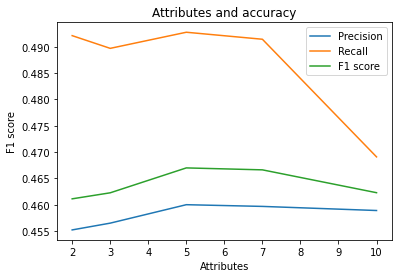

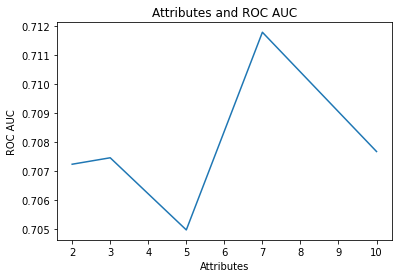

In [28]:

def plot_points(points):
    
    # Separate attributes
    a, p, r, f, o = [], [], [], [], []
    for i in range(len(points)):
        a.append(points[i][0])
        p.append(points[i][1])
        r.append(points[i][2])
        f.append(points[i][3])
        o.append(points[i][4])
    
    # Precision, recall and F1
    plt.plot(a, p, label = "Precision")
    plt.plot(a, r, label = "Recall")
    plt.plot(a, f, label = "F1 score")
    plt.title('Attributes and accuracy')
    plt.xlabel('Attributes')
    plt.ylabel('F1 score')
    plt.legend()
    plt.show()
    
    # ROC AUC
    plt.plot(a, o)
    plt.title('Attributes and ROC AUC')
    plt.xlabel('Attributes')
    plt.ylabel('ROC AUC')
    plt.show()

# Extra 7-attribute datapoint for more continuous line
gaussian7 = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['white_rating', 'black_rating', 'rating_delta', 'turns', 'opening_ply', 'eco', 'max_duration']
)

# Plot the line graphs
plot_points([gaussian10, gaussian7, gaussian5, gaussian3, gaussian2B])

## Additional observations

### Base ratings vs delta rating

Because delta_rating can be inferred from white_rating and black_rating, I had assumed it wouldn't provide any value to the classifier's output.  However, as can be seen below, switching these attributes for delta_rating actually improves the classifier's accuracy:

In [29]:
o = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['white_rating', 'black_rating', 'turns']
)

Attributes: 3
ROC AUC: 0.685
Class metrics:
 - Class 1: Precision: 0.44 Recall: 0.61 F1: 0.52
 - Class 2: Precision: 0.09 Recall: 0.21 F1: 0.13
 - Class 3: Precision: 0.77 Recall: 0.59 F1: 0.67
 - Average: Precision: 0.44 Recall: 0.47 F1: 0.44


In [30]:
o = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['rating_delta', 'turns']
)

Attributes: 2
ROC AUC: 0.707
Class metrics:
 - Class 1: Precision: 0.62 Recall: 0.61 F1: 0.61
 - Class 2: Precision: 0.08 Recall: 0.23 F1: 0.12
 - Class 3: Precision: 0.67 Recall: 0.64 F1: 0.65
 - Average: Precision: 0.46 Recall: 0.49 F1: 0.46


Improving the precision, recall and f1 score by 0.02 each, delta_rating provides better results than its component attributes - for Naive Bayes at least.  This is likely because the difference between players' skill is more important than the two evaluated separately.

Although this improves the output for Naive Bayes classification, I am unsure that it will help when using more advanced techniques that allow for a deeper understanding of complex relationships.

### Using turns to classify data


In [31]:
o = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['turns']
)

Attributes: 1
ROC AUC: 0.589
Class metrics:
 - Class 1: Precision: 0.14 Recall: 0.43 F1: 0.21
 - Class 2: Precision: 0.08 Recall: 0.21 F1: 0.12
 - Class 3: Precision: 0.86 Recall: 0.51 F1: 0.64
 - Average: Precision: 0.36 Recall: 0.39 F1: 0.32


Using only the turns attribute to classify the data does not yield good results.  On average, it gives lower precision, recall and F1 score than any of the other configurations.  However, one metric is surprisingly high.

For class 3 (Black win), the precision for classification using only the turns attribute is higher than any other configuration.  This means that, if this model predicts a black win, it is likely to be true.

I believe what the classifier may be seeing in the data is a high correlation between zero-turn games and the white player timing out.  Because matchmaking can sometimes take a long time on lichess, players may be disconnecting or leaving before a game begins, resulting in a zero-turn game where white forfeits by time-out.

## Enhancing the data further

The opening codes used up until now cover a wide range very specific opening sequences, many of which are rarely or never seen.

For instance, here are three variations of the Queen's Gambit Declined, Slav defence:

 - D17 Czech defence:   d4 d5 2. c4 c6 3. Nf3 Nf6 4. Nc3 dxc4 5. a4 Bf5
 - D18 Dutch variation: d4 d5 2. c4 c6 3. Nf3 Nf6 4. Nc3 dxc4 5. a4 Bf5 6. e3
 - D19 Dutch variation: d4 d5 2. c4 c6 3. Nf3 Nf6 4. Nc3 dxc4 5. a4 Bf5 6. e3 e6 7. Bxc4 Bb4 8. O-O

We can see that these openings are very similar as they only diverge after the 5th move.  However, the classifier can only see them as entirely separate, discrete openings.  In a perfect world, there would be enough instances for the classifier to learn their similarity but, as many of these openings only occur a few times, the classifier often doesn't make the connection.

What can be done to help this issue is to add another column with a more general opening code.  Hopefully this will allow the classifier to draw conclusions from the general opening if the specific one hasn't seen many instances.  I have copied opening data from https://www.365chess.com/eco.php and put it into a data file that can be read by this function:

In [32]:
def range_codes(range_code):
    """
    Convert a range code to set of individual codes
    For example:
        'A53' - > {'A53'}
        'A53-A55' - > {'A53', 'A54', 'A55'}
    """
    min_max = range_code.split("-")
    if len(min_max) == 1:
        return {range_code}
    
    elif len(min_max) == 2:
        letter = min_max[0][:1]
        min, max = int(min_max[0][1:]), int(min_max[1][1:])
        return { letter + f"{i:02d}" for i in range(min, max+1) }
    
    else:
        raise Exception("malformed range code")

def group_opening_codes(data, conversion_file):
    
    # Read conversion file
    opening_conversions = open('./data/opening_data.txt', 'r').read().splitlines()
    
    # Generate conversion map from file data
    conversion_map = {}
    for conversion in opening_conversions:
        split = conversion.split(" ", 1)
        range, name = split[0], split[1]
        
        for code in range_codes(range):
            conversion_map[code] = name
    
    # Add grouped column
    enhanced = data.copy()
    enhanced["grouped_eco"] = enhanced["eco"].apply( lambda code : conversion_map[code] )
    
    return enhanced
    
# Add new grouped_eco column
grouped = group_opening_codes( data, "./data/opening_data.txt" )

# Discretise and numberise data for bayes net
num_grouped = numberise(
    discretise(grouped),
    {'rated', 'status', 'white_rating', 'black_rating', 'rating_delta', 'eco', 'max_duration', 'grouped_eco'}
)

Now that the new column for a more general opening code has been added to the dataframe, we can run the bayes net again and hopefully see a classification accuracy improvement:

In [33]:
a = classifier_metrics(GaussianNB(), num_grouped, 'winner',
    ['eco']
)

Attributes: 1
ROC AUC: 0.517
Class metrics:
 - Class 1: Precision: 0.07 Recall: 0.48 F1: 0.13
 - Class 2: Precision: 0.0 Recall: 0.0 F1: 0.0
 - Class 3: Precision: 0.93 Recall: 0.5 F1: 0.65
 - Average: Precision: 0.34 Recall: 0.33 F1: 0.26


In [34]:
b = classifier_metrics(GaussianNB(), num_grouped, 'winner',
    ['grouped_eco']
)

Attributes: 1
ROC AUC: 0.51
Class metrics:
 - Class 1: Precision: 0.0 Recall: 0.0 F1: 0.0
 - Class 2: Precision: 0.0 Recall: 0.0 F1: 0.0
 - Class 3: Precision: 1.0 Recall: 0.5 F1: 0.67
 - Average: Precision: 0.33 Recall: 0.17 F1: 0.22


Maybe not...

## Linear regression


In [35]:
transformed = numberise(
    data,
    {'rated', 'eco', 'max_duration'}
)

In [51]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

def classifier_score(classifier, data, class_name, attributes=None):
    
    # Optionally get subset of attributes for attributes selection
    if attributes != None:
        if class_name not in attributes:
            attributes.append(class_name)
        data = data[attributes]
    
    # Separate model data from output
    model = data.drop([class_name], axis=1)
    output = data[class_name]
    
    # Scale model
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(model)
    model = scaling.transform(model)
    
    # Get score
    scores = cross_val_score(classifier,
        model, output,
        scoring="neg_mean_squared_error", cv=3)
    scores = np.sqrt(-scores)
    mean = scores.mean()
    
    # Derive accuracy from error and value range
    max_mean = ( data[class_name].max() - data[class_name].min() ) / 2
    accuracy = int( (max_mean-mean) / max_mean * 100 )
    
    classifier_name = str(classifier).split("(")[0]
    print( f"{classifier_name}: mean error: {mean:.2f}, accuracy: {accuracy}%" )
    return accuracy 

def classifier_scores(classifiers, data, class_name, attributes=None):
    print(f"=== class: {class_name} ===")
    out = []
    for classifier in classifiers:
        out.append( classifier_score(classifier, data, class_name, attributes) )
    print()
    return out

classifiers = [
    LinearRegression(),
    Lasso(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    # SVR(kernel="linear") # This take far too long and doesn't gove great results
]

ratings_removed = [
    "rated", "winner", "rating_delta", "eco", "opening_ply",
    "turns", "time", "increment", "max_duration"
]

classes = ["winner", "rating_delta", "opening_ply", "turns", "time", "increment", "max_duration"]

scores = []
for c in classes:
    scores.append( classifier_scores(classifiers, transformed, c, ratings_removed) )

=== class: winner ===
LinearRegression: mean error: 0.91, accuracy: 9%
Lasso: mean error: 0.98, accuracy: 2%
DecisionTreeRegressor: mean error: 1.08, accuracy: -8%
RandomForestRegressor: mean error: 0.80, accuracy: 19%

=== class: rating_delta ===
LinearRegression: mean error: 231.85, accuracy: 85%
Lasso: mean error: 231.84, accuracy: 85%
DecisionTreeRegressor: mean error: 318.49, accuracy: 79%
RandomForestRegressor: mean error: 235.78, accuracy: 84%

=== class: opening_ply ===
LinearRegression: mean error: 2.46, accuracy: 81%
Lasso: mean error: 2.80, accuracy: 79%
DecisionTreeRegressor: mean error: 1.76, accuracy: 86%
RandomForestRegressor: mean error: 1.34, accuracy: 90%

=== class: turns ===
LinearRegression: mean error: 33.03, accuracy: 81%
Lasso: mean error: 33.48, accuracy: 80%
DecisionTreeRegressor: mean error: 36.77, accuracy: 78%
RandomForestRegressor: mean error: 26.93, accuracy: 84%

=== class: time ===
LinearRegression: mean error: 789.74, accuracy: 85%
Lasso: mean error: 7

In [47]:
s = scores.copy()

[[9, 2, -8, 19],
 [85, 85, 79, 84],
 [81, 79, 86, 90],
 [81, 80, 78, 84],
 [85, 85, 97, 98],
 [86, 85, 92, 94],
 [65, 65, 96, 97]]

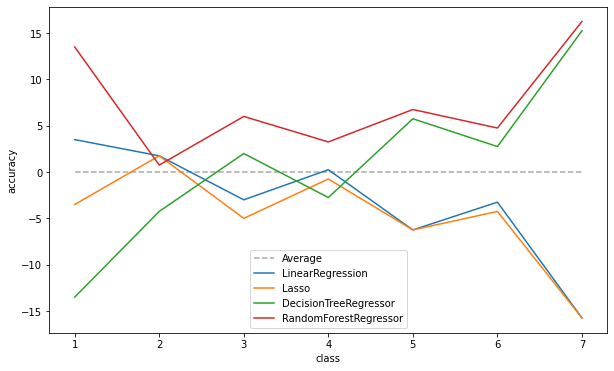

In [58]:
# Plot accuracy relative to average across classifers
for i in range(len(s)):
    mean = np.mean(s[i])
    s[i] = [x-mean for x in s[i]]

# Create plot axes
sT = np.array(s).T.tolist()
y = [i+1 for i in range(len(sT[0]))]

# Baseline
baseline = [0 for i in range(len(sT[0]))]
plt.figure(figsize=(10, 6))
plt.plot(y, baseline, '--', label="Average", color="darkgrey")

# Plot graph
classifer_names = [str(x).split("(")[0] for x in classifiers]
for i in range(len(classifer_names)):
    plt.plot(y, sT[i], label=classifer_names[i])
plt.ylabel("accuracy")
plt.xlabel("class")
plt.legend()
plt.show()